# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [1]:
import numpy as np
import pandas as pd 

from scipy.io import loadmat
from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import *
from deepymod.utilities import library_matrix_mat, print_PDE

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(42)  # setting seed for randomisation

## Prepare the data

Next, we prepare the dataset.

In [31]:
data = loadmat('Trajectories/c012_pos2.mat')
data2 = loadmat('Trajectories/c012_pos6.mat')
data3 = loadmat('Trajectories/c013_pos3.mat')
data4 = loadmat('Trajectories/c013_pos8.mat')

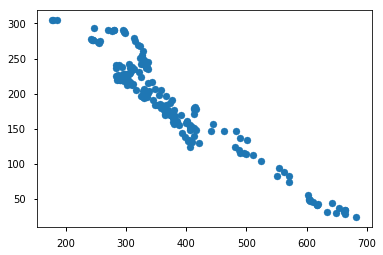

In [36]:
plt.scatter(data4['coord_cell'][0],data4['coord_cell'][1])

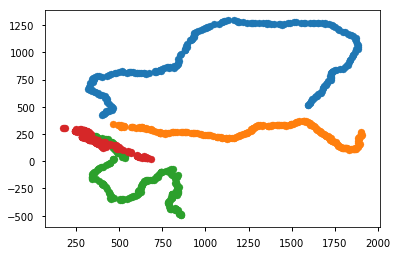

In [32]:
plt.scatter(data['coord_cell'][0],data['coord_cell'][1])
plt.scatter(data2['coord_cell'][0],data2['coord_cell'][1])
plt.scatter(data3['coord_cell'][0],data3['coord_cell'][1])
plt.scatter(data4['coord_cell'][0],data4['coord_cell'][1])

In [5]:
data = loadmat('Trakectories/c012_pos2.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((201,251,3))

x_v= usol[:,:,0]
t_v = usol[:,:,1]
y_v = usol[:,:,2]

Next we plot the dataset for three different time-points

We flatten it to give it the right dimensions for feeding it to the network:

In [6]:
X = np.transpose((t_v.flatten(),x_v.flatten()))
y = y_v.reshape((y_v.size, 1))

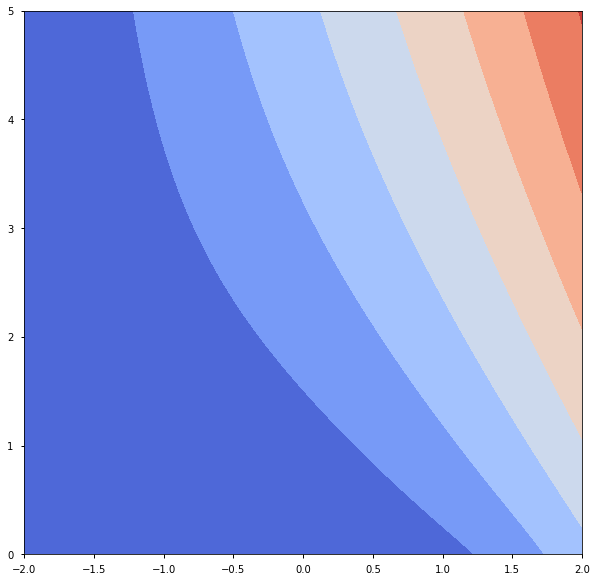

In [22]:
fig = plt.subplots(figsize=(10, 10))

plt.contourf(x_v, t_v, y_v, cmap='coolwarm')


We select the noise level we add to the data-set

In [23]:
noise_level = 0.

In [24]:
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

Select the number of samples:

In [26]:
number_of_samples = 2500

In [27]:
idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y_noisy[idx, :][:number_of_samples]

## Configure the neural network

Next we define the architecture and strength of the $L_1$ penalty for the neural network.
Note that in this example have three input channels in this example: {x,y,t}

In [30]:
config = {'layers': [2, 40, 40, 40, 40, 1], 'lambda': 10**-6}

DeepMoD accepts any arbitrary library function and any options for it can be given through *the library_config*. The library function for this example accepts a maximum order for the polynomial and derivative terms. DeepMoD also needs to know the total number of terms upfront. We can calculate that by making a list of the polynomial and derivative terms and getting all the terms by feeding them into the library_matrix_mat function. Its output will be used later to print the found PDE.

In [31]:
u = ['1', 'u']
du = ['1', 'u_{x}','u_{xx}']
coeffs_list = library_matrix_mat(u, du)
print(coeffs_list)
library_config = {'total_terms':6, 'deriv_order': 2, 'poly_order': 1}

['1', 'u_{x}', 'u_{xx}', 'u', 'uu_{x}', 'uu_{xx}']


Next we set the training options. Usually we only change the maximum iterations and the grad_tol, which sets the convergence criterion;

In [32]:
train_opts = {'max_iterations': 200000, 'grad_tol':10**-7, 'learning_rate': 0.004, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}

The last configuration we need to fill is the ouput_opts. It contains an output_directory and X_predict field. We've build a custom tensorboard so you can follow the progress of the run.  Output_directory sets where the files are saved, then simply run 

`tensorboard --logdir $[OUTPUT_DIRECTORY]`

in a terminal to open tensorboard. It shows the value of the coefficients, scaled coefficients and all possible costs. Note that the runs are timestamped in output_directory, so you'll have to add it! We can also use the output of tensorboard to analyze deepmod after. We show this below. The last option is X_predict. As DeepMoD also denoises the data, use this option to denoise some dataset X after DeepMoD has converged.

In [33]:
output_opts = {'output_directory': 'diffusion_mse/', 'X_predict': X}

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We also need to specify which library function we wish to use. You can build any library you want and just pass is through this command:

In [34]:
sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_1D, library_config, train_opts, output_opts)

u (?, 2, 1)
du (?, 1, 3)
theta (?, 2, 3)
Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [12.990449, 0.049819566, 12.820206, 0.17023756, 5.2892324e-06]
500 [0.053271636, 0.22203265, 0.04373412, 0.009536056, 1.4612972e-06]
1000 [0.021000382, 0.07469076, 0.018155405, 0.0028433786, 1.5974592e-06]
1500 [0.011423711, 0.055277277, 0.009839203, 0.0015827926, 1.7149616e-06]
2000 [0.0065794084, 0.032984532, 0.0059768124, 0.0006009152, 1.6805658e-06]
2500 [0.0046865265, 0.0237956, 0.004384688, 0.000300189, 1.6495597e-06]
3000 [0.00392041, 0.019936463, 0.0036854919, 0.00023326775, 1.6501104e-06]
3500 [0.0033746583, 0.017324692, 0.0031795101, 0.00019348509, 1.6629994e-06]
4000 [0.0029281303, 0.01498307, 0.0027756263, 0.0001508246, 1.679461e-06]
4500 [0.0025593902, 0.012772986, 0.0024449062, 0.00011278539, 1.698404e-06]
5000 [0.002261156, 0.010769196, 0.0021758345, 8.360056e-05, 1.7207949e-06]
5500 [0.0020301763, 0.011462272, 0.001966369, 6.205884e-05, 1.748316e-06]
6000 [0.0018731073, 0.0151

KeyboardInterrupt: 

Show final result:

In [56]:


print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 4.401u_{xx} + 1.222uu_{xx}


Plot the 'Ground truth', 'Noisy' and 'Reconstructed/Denoised' solution

In [22]:
X_predict = X[(X[:,0]==5.0) | (X[:,0]==9.0) | (X[:,0]==7.0), :]

In [23]:
data_dict = {'x_grid': X[:,1],'y_grid': X[:,2], 't_grid': X[:,0], 'ground_truth': np.squeeze(y), 'noisy': np.squeeze(y_noisy)}
df = pd.DataFrame(data_dict)
for key in df:
    df[key] = np.squeeze(df[key])
data = pd.DataFrame(df)

In [24]:
data_dict_denoised = {'x_grid': X[:,1],'y_grid': X[:,2], 't_grid': X[:,0], 'denoised': np.squeeze(denoised)}
df_dn = pd.DataFrame(data_dict_denoised)
for key in df_dn:
    df_dn[key] = np.squeeze(df_dn[key])
data_denoised = pd.DataFrame(df_dn)

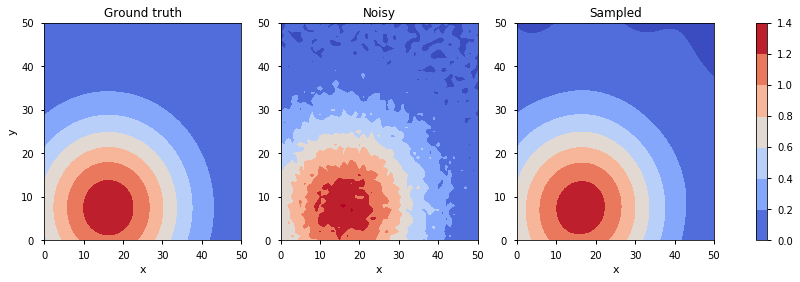

In [31]:
time1 = 7.0

vmin = np.min(data[data['t_grid'] == time1]['ground_truth'])
vmax = np.max(data[data['t_grid'] == time1]['ground_truth'])

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im1 = axes[0].contourf(pd.pivot_table(data[data['t_grid'] == time1],index='y_grid', columns='x_grid', values='ground_truth'), cmap='coolwarm',vmin=vmin, vmax=vmax)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Ground truth')

im2 = axes[1].contourf(pd.pivot_table(data[data['t_grid'] == time1],index='y_grid', columns='x_grid', values='noisy'), cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

im3 = axes[2].contourf(pd.pivot_table(data_denoised[data_denoised['t_grid'] == time1],index='y_grid', columns='x_grid', values='denoised'), cmap='coolwarm', vmin=vmin, vmax=vmax)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()